<a href="https://colab.research.google.com/github/ArjunVerma/Transfer-Learning/blob/master/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Libraries

In [0]:
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import numpy as np
import os

In [0]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop

##Helper Functions

### Helper function for joining paths

In [0]:
def path_join(dir_name, filenames):
  return [os.path.join(dir_name, filename) for filename in filenames]

### Helper function for loading images

In [0]:
def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

### Helper function for plotting accuracy and loss

In [0]:
def plot_training_history(history):
  acc = history.history['categorical_accuracy']
  loss = history.history['loss']
  
  val_acc = history.history['val_categorical_accuracy']
  val_loss = history.history['val_loss']
  
  plt.plot(acc, linestyle= '-', color='b', label= 'Train Accuracy')
  plt.plot(loss, 'o', color= 'b', label= 'Train loss')
  
  plt.plot(val_acc, linestyle= '--', color= 'r', label= 'Test Accuracy')
  plt.plot(val_loss, 'o', color= 'r', label= 'Test loss')
  
  plt.title('Train-Test Accuracy and Loss').set_color('white')
  plt.legend()
  
  plt.show()

### Helper function for plotting images (at max 9)

In [0]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()


### Helper function for confusion matrix

In [0]:
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):
    
    cm = confusion_matrix(y_true=cls_test_num,
                          y_pred=cls_pred)

    print("Confusion matrix:")
    print(cm)
    
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

### Helper function for plotting example errors

In [0]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != cls_test_num)

    image_paths = np.array(image_test_path)[incorrect]

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[0:9])
    
    cls_pred = cls_pred[incorrect]
    cls_true = cls_test_num[incorrect]
    
    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Helper fucntion for Example Errors

In [0]:
def example_errors():
    # The Keras data-generator for the test-set must be reset
    # before processing. This is because the generator will loop
    # infinitely and keep an internal index into the dataset.
    # So it might start in the middle of the test-set if we do
    # not reset it first. This makes it impossible to match the
    # predicted classes with the input images.
    # If we reset the generator, then it always starts at the
    # beginning so we know exactly which input-images were used.
    generator_test.reset()
    
    y_pred = new_model.predict_generator(generator_test,
                                         steps=steps_test)

    
    cls_pred = np.argmax(y_pred,axis=1)

    # Plot examples of mis-classified images.
    plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
    print_confusion_matrix(cls_pred)

###Dataset

In [0]:
import knifey

In [12]:
knifey.maybe_download_and_extract()

- Download progress: 100.0%
Download finished. Extracting files.
Done.


In [13]:
knifey.copy_files()

Creating dataset from the files in: data/knifey-spoony/
- Data saved to cache-file: data/knifey-spoony/knifey-spoony.pkl
- Copied training-set to: data/knifey-spoony/train/
- Copied test-set to: data/knifey-spoony/test/


In [0]:
train_dir = knifey.train_dir
test_dir = knifey.test_dir

### Code Implementation

In [15]:
model = VGG16(include_top= True, weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.
553467904/553467096 [==============================] - 41s 0us/step


In [16]:
input_shape = model.layers[0].output_shape
print(input_shape)
input_shape = input_shape[1:3]
print(input_shape)

(None, 224, 224, 3)
(224, 224)


In [0]:
datagen_train = ImageDataGenerator(
    rescale= 1./255,
    rotation_range= 180,
    width_shift_range= 0.1,
    height_shift_range= 0.1,
    shear_range= 0.1,
    zoom_range= [0.9, 1.5],
    horizontal_flip= True,
    vertical_flip= True,
    fill_mode= 'nearest'
)

In [0]:
datagen_test = ImageDataGenerator(rescale= 1./255)

In [0]:
batch_size= 20

In [0]:
if True:
  save_to_dir= None
else:
  save_to_dir= 'augmented_images/'

In [21]:
generator_train = datagen_train.flow_from_directory(
    directory= train_dir,
    target_size= input_shape,
    batch_size= batch_size,
    shuffle= True,
    save_to_dir= save_to_dir
)

Found 4170 images belonging to 3 classes.


In [22]:
generator_test = datagen_test.flow_from_directory(
    directory= test_dir,
    target_size= input_shape,
    batch_size= batch_size,
    shuffle= False
)

Found 530 images belonging to 3 classes.


In [23]:
steps_test = generator_test.n / batch_size
steps_test

26.5

In [24]:
print(generator_train.filenames[0])
print(train_dir)

forky/forky-01-0001.jpg
data/knifey-spoony/train/


In [0]:
## USING HELPER FUNCTION TO JOIN PATHS
image_train_path = path_join(train_dir, generator_train.filenames)
image_test_path = path_join(test_dir, generator_test.filenames)

In [26]:
image_train_path[0]

'data/knifey-spoony/train/forky/forky-01-0001.jpg'

In [27]:
## Getting the class number of class for every image
cls_train_num = generator_train.classes
cls_test_num = generator_test.classes
print(np.unique(cls_train_num))
print(np.unique(cls_test_num))

[0 1 2]
[0 1 2]


In [28]:
## Getting class names for class numbers obtained
class_names = list(generator_train.class_indices.keys())
print(class_names)

['forky', 'knifey', 'spoony']


In [29]:
num_classes = generator_train.num_classes
print(num_classes)

3


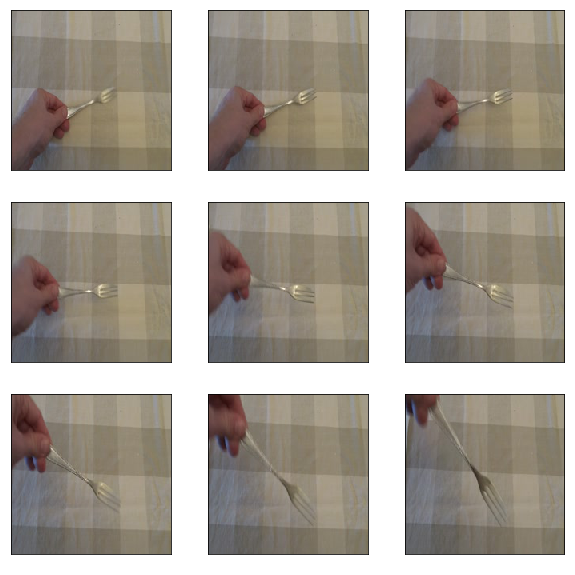

In [30]:
## Plottig few images
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  image = plt.imread(image_train_path[i])
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(class_names[cls_train_num[i]]).set_color('white')
  plt.imshow(image)
plt.show()

##Class Weight Assigning

In [0]:
from sklearn.utils.class_weight import compute_class_weight

In [0]:
class_weight = compute_class_weight(
    class_weight= 'balanced',
    classes= np.unique(cls_train_num),
    y= cls_train_num
)

In [33]:
class_weight

array([1.39839034, 1.14876033, 0.70701933])

In [34]:
class_names

['forky', 'knifey', 'spoony']

### Example Prediction

In [0]:
def predict(image_path):
  image = PIL.Image.open(image_path)
  image_resized = image.resize(input_shape, PIL.Image.LANCZOS)
  
  plt.xticks([])
  plt.yticks([])
  plt.imshow(image_resized)
  plt.show()
  
  img_array = np.expand_dims(np.array(image_resized), axis=0)
  
  pred = model.predict(img_array)
  
  pred_decode = decode_predictions(pred)[0]
  
  for code, name, score in pred_decode:
    print('{0}% : {1}'.format(round(score*100, 2), name))

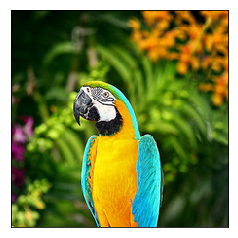

40960/35363 [==================================] - 0s 5us/step
79.02% : macaw
6.61% : bubble
3.64% : vine_snake
1.9% : pinwheel
1.22% : knot


In [36]:
predict(image_path= 'images/parrot_cropped1.jpg')

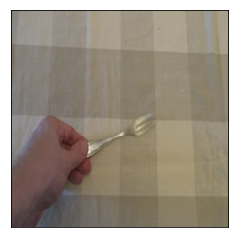

50.31% : shower_curtain
17.08% : handkerchief
12.75% : mosquito_net
2.87% : window_shade
1.32% : toilet_tissue


In [37]:
predict(image_path= image_train_path[0])

## Transfer Learning

In [38]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
transfer_layer = model.get_layer('block5_pool')

In [40]:
transfer_layer.output

<tf.Tensor 'block5_pool/MaxPool:0' shape=(?, 7, 7, 512) dtype=float32>

In [0]:
conv_model = Model(inputs= model.input, outputs= transfer_layer.output)

In [42]:
new_model = Sequential()

new_model.add(conv_model)
new_model.add(Flatten())
new_model.add(Dense(1024, activation='relu'))
### Adding a dropout layer which prevents overfitting and adds generalization ability to unseen data
new_model.add(Dropout(0.5))
new_model.add(Dense(num_classes, activation= 'softmax'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
optimizer= Adam(lr=1e-5)

In [0]:
loss= 'categorical_crossentropy'

In [0]:
metrics= ['categorical_accuracy']

In [46]:
### Checking Trainable layer in model

for layer in conv_model.layers:
  print('{0} : {1}'.format(layer.trainable, layer.name))

True : input_1
True : block1_conv1
True : block1_conv2
True : block1_pool
True : block2_conv1
True : block2_conv2
True : block2_pool
True : block3_conv1
True : block3_conv2
True : block3_conv3
True : block3_pool
True : block4_conv1
True : block4_conv2
True : block4_conv3
True : block4_pool
True : block5_conv1
True : block5_conv2
True : block5_conv3
True : block5_pool


In [0]:
### Making model untrainable because we want to use model as it is.
conv_model.trainable = False

In [48]:
### Making layers of model untrainable
for layer in conv_model.layers:
  layer.trainable = False
  print('{0} : {1}'.format(layer.trainable, layer.name))

False : input_1
False : block1_conv1
False : block1_conv2
False : block1_pool
False : block2_conv1
False : block2_conv2
False : block2_pool
False : block3_conv1
False : block3_conv2
False : block3_conv3
False : block3_pool
False : block4_conv1
False : block4_conv2
False : block4_conv3
False : block4_pool
False : block5_conv1
False : block5_conv2
False : block5_conv3
False : block5_pool


In [0]:
new_model.compile(optimizer= optimizer, loss= loss, metrics= metrics)

In [0]:
steps_per_epoch = 100
epochs = 20

In [51]:
history = new_model.fit_generator(
    generator= generator_train,
    epochs= epochs,
    steps_per_epoch= steps_per_epoch,
    class_weight= class_weight,
    validation_data= generator_test,
    validation_steps= steps_test
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
209/209 [==============================] - 57s 275ms/step - loss: 1.0114 - categorical_accuracy: 0.5115 - val_loss: 0.7204 - val_categorical_accuracy: 0.7434
Epoch 2/20
209/209 [==============================] - 53s 256ms/step - loss: 0.7979 - categorical_accuracy: 0.6309 - val_loss: 0.6172 - val_categorical_accuracy: 0.7887
Epoch 3/20
209/209 [==============================] - 52s 251ms/step - loss: 0.6970 - categorical_accuracy: 0.6986 - val_loss: 0.6104 - val_categorical_accuracy: 0.7736
Epoch 4/20
209/209 [==============================] - 54s 258ms/step - loss: 0.6378 - categorical_accuracy: 0.7331 - val_loss: 0.5626 - val_categorical_accuracy: 0.7906
Epoch 5/20
209/209 [==============================] - 54s 256ms/step - loss: 0.6021 - categorical_accuracy: 0.7432 - val_loss: 0.6079 - val_categorical_accuracy: 0.7415
Epoch 6/20
209/209 [==============================] - 55s 263ms/step - loss: 0.5645 - categorical_accuracy:

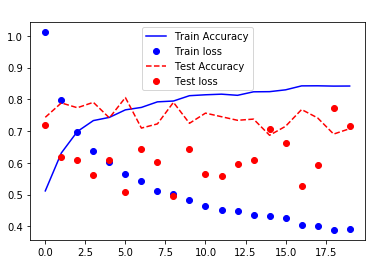

In [52]:
plot_training_history(history= history)

In [53]:
result = new_model.evaluate_generator(generator_test, steps= steps_test)
print(result)

[0.7162351953210654, 0.7075472]


In [54]:
print('Test-set accuracy : {0:.2%}'.format(result[1]))

Test-set accuracy : 70.75%


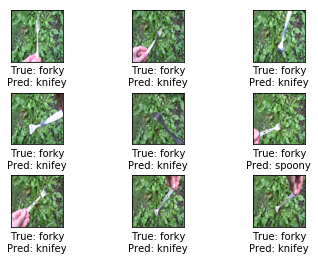

Confusion matrix:
[[140  10   1]
 [ 50  87   0]
 [ 86   8 148]]
(0) forky
(1) knifey
(2) spoony


In [55]:
example_errors()

## Fine Tuning

In [0]:
conv_model.trainable = True

In [0]:
for layer in conv_model.layers:
  trainable = ('block5' in layer.name or 'block4' in layer.name)
  layer.trainable = trainable

In [61]:
for layer in conv_model.layers:
  print('{0} : {1}'.format(layer.trainable, layer.name))

False : input_1
False : block1_conv1
False : block1_conv2
False : block1_pool
False : block2_conv1
False : block2_conv2
False : block2_pool
False : block3_conv1
False : block3_conv2
False : block3_conv3
False : block3_pool
True : block4_conv1
True : block4_conv2
True : block4_conv3
True : block4_pool
True : block5_conv1
True : block5_conv2
True : block5_conv3
True : block5_pool


In [0]:
optimizer_fine = Adam(lr= 1e-7)

In [0]:
new_model.compile(
    optimizer= optimizer_fine,
    loss= loss,
    metrics= metrics
)

In [64]:
new_model.fit_generator(
    generator= generator_train,
    epochs= epochs,
    steps_per_epoch= steps_per_epoch,
    class_weight= class_weight,
    validation_data= generator_test,
    validation_steps= steps_test
)

Epoch 1/20
209/209 [==============================] - 60s 286ms/step - loss: 0.3731 - categorical_accuracy: 0.8540 - val_loss: 0.6789 - val_categorical_accuracy: 0.7113
Epoch 2/20
209/209 [==============================] - 58s 280ms/step - loss: 0.3640 - categorical_accuracy: 0.8547 - val_loss: 0.6692 - val_categorical_accuracy: 0.7170
Epoch 3/20
209/209 [==============================] - 59s 280ms/step - loss: 0.3460 - categorical_accuracy: 0.8652 - val_loss: 0.6636 - val_categorical_accuracy: 0.7189
Epoch 4/20
209/209 [==============================] - 57s 274ms/step - loss: 0.3472 - categorical_accuracy: 0.8662 - val_loss: 0.6634 - val_categorical_accuracy: 0.7208
Epoch 5/20
209/209 [==============================] - 59s 284ms/step - loss: 0.3376 - categorical_accuracy: 0.8700 - val_loss: 0.6460 - val_categorical_accuracy: 0.7321
Epoch 6/20
209/209 [==============================] - 59s 283ms/step - loss: 0.3453 - categorical_accuracy: 0.8645 - val_loss: 0.6527 - val_categorical_acc

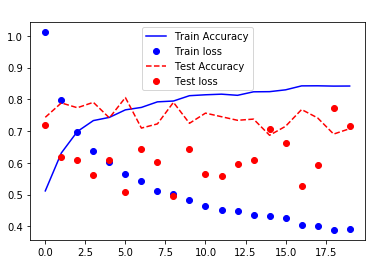

In [66]:
plot_training_history(history)

In [67]:
result = new_model.evaluate_generator(generator_test, steps= steps_test)
print(result)

[0.6252103401003061, 0.76037735]


In [71]:
print('Test Accuracy after fine tuning : {0:.2%}'.format(result[1]))

Test Accuracy after fine tuning : 76.04%
